In [1]:

import json

with open("data/all_formatted_pre_data.json") as f:
    coin_data = json.load(f)


In [32]:
##ここで銘柄の選択を行う
data = coin_data["0x"]

price = data["price"]
volume = data["volume"]
print(data)

{'price': [0.14843194621298808, 0.1509345469009596, 0.15629538149174635, 0.15452675383076084, 0.1584801667504877, 0.1571219818514383, 0.1612201105638955, 0.1581338408006639, 0.16572439764987365, 0.1695663290030349, 0.17380269068166748, 0.17802661052792187, 0.18285877128689462, 0.18998965939282356, 0.20550274920720485, 0.20340827341819248, 0.20934427817142712, 0.20880078097413654, 0.19900051140847552, 0.20467395756067291, 0.2183876657932324, 0.2211954345730731, 0.22987709084761607, 0.22744057353636982, 0.21873971384956215, 0.22634199373386138, 0.22816956286802959, 0.24149169042638205, 0.23097095066301518, 0.2364251271665314, 0.2150546002802446, 0.21696380616200492, 0.22665376298905174, 0.23433081015486387, 0.2549098228039264, 0.25984356700490535, 0.24947020696323538, 0.24530546010328785, 0.26110688726640396, 0.2552151863456048, 0.22968723839396737, 0.2331569300525811, 0.24301454975705028, 0.23407687289479462, 0.22480773423376238, 0.23350729195436823, 0.25417068112760816, 0.2419023522261

In [24]:
coin_data.keys()

dict_keys(['0x', '1inch', 'bakerytoken', 'aave', 'aavegotchi', 'acala', 'adventure-gold', 'aergo', 'airswap', 'akropolis', 'alchemix', 'alchemy-pay', 'algorand', 'alien-worlds', 'aptos-launch-token', 'wrapped-solana', 'alpaca-finance', 'alpine-f1-team-fan-token', 'amber', 'amp-token', 'ampleforth-governance-token', 'anchor-protocol', 'ankr', 'anyswap', 'api3', 'aptos', 'aragon', 'ardor', 'arpa', 'arweave', 'as-roma-fan-token', 'atletico-madrid', 'auction', 'audius-wormhole', 'aurora-dao', 'auto', 'automata', 'concierge-io', 'axl-inu', 'axie-infinity', 'badger-dao', 'balancer', 'bancor', 'band-protocol', 'barnbridge', 'biswap', 'bifi', 'bella-protocol', 'qiswap', 'biconomy', 'matic-network', 'bitcoin-cash', 'eos', 'filecoin', 'zcoin', 'iotex', 'litecoin', 'near', 'ontology', 'xcdot', 'tezos', 'bitcoin-gold', 'bitshares', 'bittorrent', 'stox', 'bluzelle', 'bonfida', 'curve-dao-token', 'true-usd', 'btc-standard-hashrate-token', 'cartesi', 'cow-protocol', 'celer-network', 'tia', 'tranchess

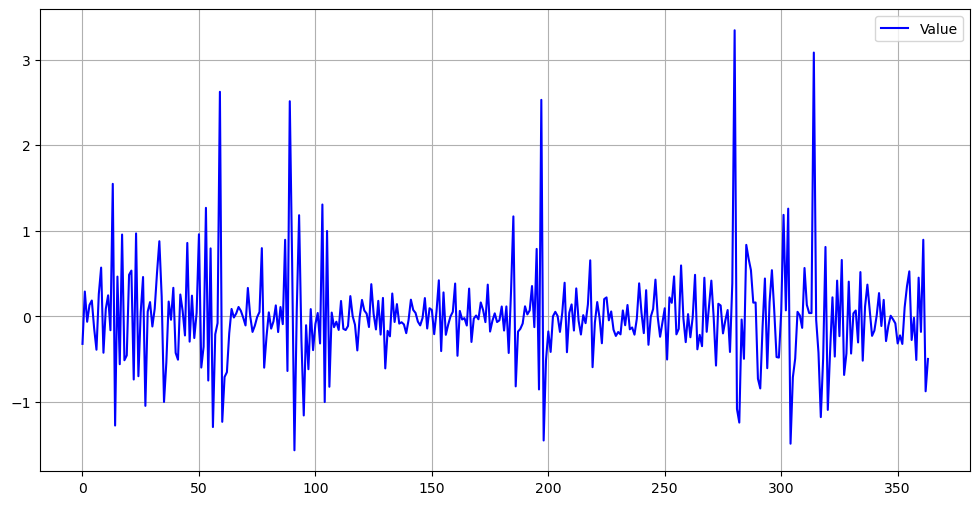

0.000276518540603766


In [33]:

import numpy as np

# 対数を取り、差分を計算
volume_log = list(np.log(volume))

volume_log_diff = []

for i in range(len(volume_log)-1):
    volume_log_diff.append(volume_log[i+1] - volume_log[i])

import matplotlib.pyplot as plt

# 時系列データのプロット
plt.figure(figsize=(12, 6))
plt.plot([i for i in range(len(volume_log_diff))], volume_log_diff, label='Value', color='b')  # 'Value'はプロットしたいカラム名
plt.legend()
plt.grid(True)
plt.show()

print(sum(volume_log_diff)/len(volume_log_diff))

## 対数階差をとる

In [8]:
import numpy as np

def get_log_diff(data):
    # 対数を取り、差分を計算
    volume_log = list(np.log(data))

    volume_log_diff = []

    for i in range(len(volume_log)-1):
        volume_log_diff.append(volume_log[i+1] - volume_log[i])
    
    return volume_log_diff


In [7]:
volume_log_diff = get_log_diff(volume)

NameError: name 'volume' is not defined

### 定常性の検定

In [26]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(volume_log_diff)

print("ADF Statistic:", end=" ")
print(result[0])

for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
print("p-value:", end=" ")
print(result[1])

ADF Statistic: -7.65861978282931
	1%: -3.449
	5%: -2.870
	10%: -2.571
p-value: 1.7122454950970714e-11


In [10]:
from collections import defaultdict
model_param = defaultdict(list)

## ARモデルのパラメータ決定

In [34]:
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

def AR_param(data):
    order = ar_select_order(data,maxlag=10, ic="aic")
    best_order = order.ar_lags[-1]

    model = AutoReg(data, lags=best_order)
    model_fit = model.fit()

    return best_order, model_fit.params[0], model_fit.params[1:]



In [35]:
test = AR_param(volume_log_diff)

In [36]:
test

(4,
 0.0022989742985026025,
 array([-0.31019471, -0.19608227, -0.19688207, -0.10646878]))

## ARCHモデルのパラメータ決定

In [13]:
from arch import arch_model

def ARCH_param(data):
    model = arch_model(data, vol="ARCH", p=1)
    model_fit = model.fit()

    return model_fit.params["omega"], model_fit.params["alpha[1]"]


## 価格の変動についてのパラメータ決定

In [22]:
## 対数階差をとる

import numpy as np

# 対数を取り、差分を計算

def price_log_diff(data):
    price_log = list(np.log(data))

    price_log_diff = []

    for i in range(len(price_log)-1):
        price_log_diff.append((price_log[i+1] - price_log[i])*100)
    return price_log_diff


### AIC計算関数

In [23]:
import math

## model_data→生成されたデータリスト
## data→元のデータリスト
## t→生成されたデータの長さ
## p→ARモデルの次元数
def aic(model_data, data, t, p):
    sum_value = 0
    for i in range(len(model_data)):
        sum_value += (model_data[i] - data[i+p]) ** 2
    return math.log(sum_value/t) + 2*(p+1)/t

### モデルを使ってデータを生成するための関数

In [24]:
import numpy as np

## test_param→値を得たいパラメータ
def model_check(const, a, omega, b, p, test_param, volume_data, value_data):
    a.reverse()
    volatility = [np.random.normal(loc=0, scale=1)]
    generated_data_value = []
    for i in range(len(volume_data)-p):
        x = 0
        for j in range(p):
            x += volume_data[i+j] + a[j] + const
            if j == p-1:
                x += (value_data[i+j]) * test_param
        vol = (b * volatility[-1] + omega) * np.random.normal(loc=0, scale=1) 
        x += vol
        volatility.append(vol)
        generated_data_value.append(x)
    return generated_data_value


### パラメータ推定

In [25]:
import matplotlib.pyplot as plt

def param_estimate(main_data, sub_data, const, a, omega, b, p):
    check_data = []

    for i in range(1, 2001):
        test_param = (i-1000)/1000
        param_return = model_check(const=const, a=list(a), omega=omega, b=b, p=p, test_param=test_param, volume_data=main_data, value_data=sub_data)
        target_value = aic(model_data=param_return, data=main_data, t=len(main_data), p=p)
        check_data.append(target_value)

    price_param = (check_data.index(min(check_data))-1000)/1000
    return price_param


In [16]:
check_data = []

for i in range(1, 2001):
    test_param = (i-1000)/1000
    param_return = model_check(const=const, a=list(a), omega=omega, b=b, p=p, test_param=test_param, volume_data=main_data, value_data=sub_data)
    target_value = aic(model_data=param_return, data=main_data, t=len(main_data), p=p)
    check_data.append(target_value)

price_param = (check_data.index(min(check_data))-1000)/1000
plt.figure(figsize=(12, 6))
plt.plot([i for i in range(len(check_data))], check_data, label='Value', color='b')  # 'Value'はプロットしたいカラム名
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'const' is not defined

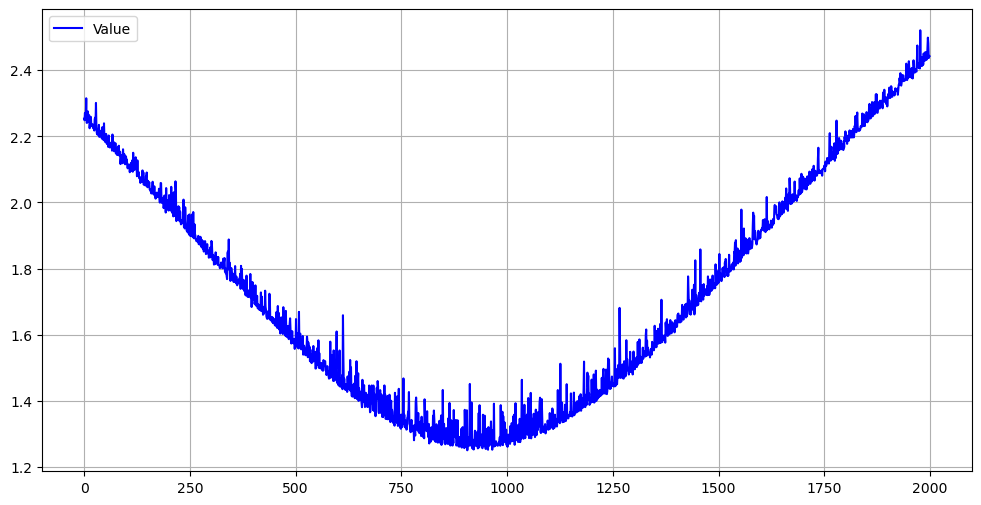

In [136]:
import matplotlib.pyplot as plt

# 時系列データのプロット
plt.figure(figsize=(12, 6))
plt.plot([i for i in range(len(check_data))], check_data, label='Value', color='b')  # 'Value'はプロットしたいカラム名
plt.legend()
plt.grid(True)
plt.show()


## 生成されたパラメータの保存

In [137]:
save_data = [const, a, omega, b, price_param]

model_param["ADABTC"] = save_data

In [26]:
from collections import defaultdict

save_values = {}
error_key = []
i = 1
for key, value in coin_data.items():
    try:
        print(len(value["volume"]))
        model_param = defaultdict(list)
        save_data = defaultdict(list)
        price_value = value["price"]
        volume_value = value["volume"]
        price_formatted_value = price_log_diff(price_value)
        volume_formatted_value = get_log_diff(volume_value)
        print(len(volume_formatted_value))
        p, const, a = AR_param(volume_formatted_value)
        save_data["p"] = p
        save_data["a"] = a
        save_data["const"] = const
        omega, b = ARCH_param(volume_formatted_value)
        save_data["omega"] = omega
        save_data["b"] = b
        param_estimate_value = param_estimate(main_data=volume_formatted_value, sub_data=price_formatted_value, const=const, a=a, omega=omega, b=b, p=p)
        save_data["param_estimate_value"] = param_estimate_value
        save_values[key] = save_data
    except:
        error_key.append(key)


365
364
Iteration:      1,   Func. Count:      5,   Neg. LLF: 2152.8260728635196
Iteration:      2,   Func. Count:     13,   Neg. LLF: 614.2914618945542
Iteration:      3,   Func. Count:     20,   Neg. LLF: 297.9772380996036
Iteration:      4,   Func. Count:     25,   Neg. LLF: 290.45653124243006
Iteration:      5,   Func. Count:     29,   Neg. LLF: 290.45592651050856
Iteration:      6,   Func. Count:     33,   Neg. LLF: 290.4559250202922
Iteration:      7,   Func. Count:     36,   Neg. LLF: 290.4559250202941
Optimization terminated successfully    (Exit mode 0)
            Current function value: 290.4559250202922
            Iterations: 7
            Function evaluations: 36
            Gradient evaluations: 7
365
364
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1890434758570.248
Iteration:      2,   Func. Count:     13,   Neg. LLF: 68221.00280147749
Iteration:      3,   Func. Count:     19,   Neg. LLF: 333.376492515962
Iteration:      4,   Func. Count:     25,   Neg. LLF: 2

/Users/hiroki/anaconda3/lib/python3.10/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.05065. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


365
364
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1609.5004373583756
Iteration:      2,   Func. Count:     12,   Neg. LLF: 2344.8793859046045
Iteration:      3,   Func. Count:     19,   Neg. LLF: 348.9780735513697
Iteration:      4,   Func. Count:     24,   Neg. LLF: 340.4489957520293
Iteration:      5,   Func. Count:     28,   Neg. LLF: 340.44898750372704
Iteration:      6,   Func. Count:     31,   Neg. LLF: 340.4489875037651
Optimization terminated successfully    (Exit mode 0)
            Current function value: 340.44898750372704
            Iterations: 6
            Function evaluations: 31
            Gradient evaluations: 6
365
364
Iteration:      1,   Func. Count:      5,   Neg. LLF: 10658.886505901519
Iteration:      2,   Func. Count:     12,   Neg. LLF: 679.9578029060782
Iteration:      3,   Func. Count:     19,   Neg. LLF: 348.5488787585731
Iteration:      4,   Func. Count:     24,   Neg. LLF: 348.03592310844135
Iteration:      5,   Func. Count:     28,   Neg. LL

/var/folders/56/psj7ncmx4wg4kv9hzqkrrnmc0000gn/T/ipykernel_6532/2608322591.py:5: RuntimeWarning: divide by zero encountered in log
  volume_log = list(np.log(data))
/var/folders/56/psj7ncmx4wg4kv9hzqkrrnmc0000gn/T/ipykernel_6532/2608322591.py:10: RuntimeWarning: invalid value encountered in double_scalars
  volume_log_diff.append(volume_log[i+1] - volume_log[i])


365
364
Iteration:      1,   Func. Count:      5,   Neg. LLF: 723142.3049036369
Iteration:      2,   Func. Count:     13,   Neg. LLF: 155431.48724481527
Iteration:      3,   Func. Count:     19,   Neg. LLF: 209.3502898469145
Iteration:      4,   Func. Count:     25,   Neg. LLF: 192.0584164052811
Iteration:      5,   Func. Count:     29,   Neg. LLF: 192.0583613798824
Iteration:      6,   Func. Count:     33,   Neg. LLF: 192.05834509714327
Iteration:      7,   Func. Count:     36,   Neg. LLF: 192.05834509714413
Optimization terminated successfully    (Exit mode 0)
            Current function value: 192.05834509714327
            Iterations: 7
            Function evaluations: 36
            Gradient evaluations: 7
365
364
Iteration:      1,   Func. Count:      5,   Neg. LLF: 2195.838736099303
Iteration:      2,   Func. Count:     13,   Neg. LLF: 733.7464392780448
Iteration:      3,   Func. Count:     20,   Neg. LLF: 398.3186139386535
Iteration:      4,   Func. Count:     25,   Neg. LLF:

/Users/hiroki/anaconda3/lib/python3.10/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.05863. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


365
364
Iteration:      1,   Func. Count:      5,   Neg. LLF: 2113.8092508855434
Iteration:      2,   Func. Count:     13,   Neg. LLF: 539.4971206987414
Iteration:      3,   Func. Count:     20,   Neg. LLF: 228.26434638115748
Iteration:      4,   Func. Count:     25,   Neg. LLF: 221.70784978789425
Iteration:      5,   Func. Count:     29,   Neg. LLF: 221.68516350964313
Iteration:      6,   Func. Count:     33,   Neg. LLF: 221.6838667974241
Iteration:      7,   Func. Count:     37,   Neg. LLF: 221.68384821175601
Iteration:      8,   Func. Count:     40,   Neg. LLF: 221.68384821173618
Optimization terminated successfully    (Exit mode 0)
            Current function value: 221.68384821175601
            Iterations: 8
            Function evaluations: 40
            Gradient evaluations: 8
365
364
Iteration:      1,   Func. Count:      5,   Neg. LLF: 1146.226746952896
Iteration:      2,   Func. Count:     12,   Neg. LLF: 1006.2054166836763
Iteration:      3,   Func. Count:     19,   Neg. 

In [10]:
save_values

{'0x': defaultdict(list,
             {'p': 4,
              'a': array([-0.31019471, -0.19608227, -0.19688207, -0.10646878]),
              'const': 0.0022989742985026025,
              'omega': 0.21271402808274562,
              'b': 0.4529814093656944,
              'param_estimate_value': -0.072}),
 '1inch': defaultdict(list,
             {'p': 6,
              'a': array([-0.39775393, -0.29730087, -0.19122733, -0.10684535, -0.10315837,
                     -0.11515057]),
              'const': 0.004930291799628571,
              'omega': 0.16182911417123247,
              'b': 0.22324541957527758,
              'param_estimate_value': 0.019}),
 'bakerytoken': defaultdict(list,
             {'p': 7,
              'a': array([-0.24571658, -0.26269629, -0.22784161, -0.25174725, -0.13946292,
                     -0.15455986, -0.08731057]),
              'const': 0.028781817129330606,
              'omega': 0.23869528036871346,
              'b': 0.18959915204390948,
              'par

In [27]:
for key, value in save_values.items():
    value["a"] = list(value["a"])



In [34]:
for key, value in save_values.items():
    temp = []
    for x in value["a"]:
        temp.append(float(str(x)[:6]))
    value["a"] = temp
    value["const"] = float(str(value["const"])[:6])
    value["b"] = float(str(value["b"])[:6])
    value["omega"] = float(str(value["omega"])[:6])

save_values
    

defaultdict(collections.defaultdict,
            {'0x': defaultdict(list,
                         {'p': 4,
                          'a': [-0.31, -0.196, -0.196, -0.106],
                          'const': 0.0022,
                          'omega': 0.2127,
                          'b': 0.4529,
                          'param_estimate_value': -0.059}),
             '1inch': defaultdict(list,
                         {'p': 6,
                          'a': [-0.397,
                           -0.297,
                           -0.191,
                           -0.106,
                           -0.103,
                           -0.115],
                          'const': 0.0049,
                          'omega': 0.1618,
                          'b': 0.2232,
                          'param_estimate_value': -0.006}),
             'bakerytoken': defaultdict(list,
                         {'p': 7,
                          'a': [-0.245,
                           -0.262,
             

In [28]:
save_values

{'0x': defaultdict(list,
             {'p': 4,
              'a': [-0.3101947111430081,
               -0.19608226586922056,
               -0.19688207050584214,
               -0.10646877739196832],
              'const': 0.0022989742985026025,
              'omega': 0.21271402808274562,
              'b': 0.4529814093656944,
              'param_estimate_value': -0.054}),
 '1inch': defaultdict(list,
             {'p': 6,
              'a': [-0.3977539303783955,
               -0.2973008688280114,
               -0.19122732686032026,
               -0.10684535085077952,
               -0.10315836591171423,
               -0.11515056728400172],
              'const': 0.004930291799628571,
              'omega': 0.16182911417123247,
              'b': 0.22324541957527758,
              'param_estimate_value': -0.001}),
 'bakerytoken': defaultdict(list,
             {'p': 7,
              'a': [-0.2457165844581463,
               -0.26269629112870363,
               -0.22784160982974078,

In [29]:
import numpy as np
import json

class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        return super().default(obj)

with open("data/all_param_pre_data.json", "w") as file:
    json.dump(save_values, file, cls=NumpyEncoder, indent=4)